# Part 1: Code to process the tensorboard output: Trainability Analysis

In [27]:
from packaging import version

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb
import statistics as st
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os
import numpy as np
import random
import time
import math
import pickle


In [28]:
#Important Functions to process event files of tensorboard

weight = 0.995
def smooth(scalars: list, weight: float=0.995) -> list:  # Weight between 0 and 1
    '''
    The function used to smoothen the return vs episodes curve
    '''
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    std = 0
    var = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
        delta = -1 if point - smoothed_val < -1 else point - smoothed_val
        var.append(delta)
    return smoothed, var


def import_data_from_multiple_runs(batch_path):
    '''The function is used to import tensorboard log files from multiple runs. 
    batch_path contains multiple run_dirs and each run_dir contains the summary folder where the tensorboard event is stored'''
    sub_dirs = [x for x in os.walk(batch_path)]
    summary_paths = [os.path.join(os.path.join(batch_path, folder), "summary") for folder in sub_dirs[0][1]]
    out = {"r": [], "e": [], "tt":[], "step": []}
    for path in summary_paths:
        returns_list, entropy_list, actual_training_time = get_data_from_single_run(path)
        out["r"].append(returns_list)
        out["e"].append(entropy_list)
        out["tt"].append(actual_training_time)
    return out

def get_data_from_single_run(path):
    '''This function is used to load data from a single run_dir. 
    path is the path of the summary_dir inside the run_dir where the tensorboard event is stored'''
    event_acc = EventAccumulator(path)
    event_acc.Reload()
    w_times, step, value = zip(*event_acc.Scalars('Return/Reward'))
    returns_list = list(value)
    w_times, step, value = zip(*event_acc.Scalars('Stats/Entropy'))
    entropy_list = list(value)
    actual_training_time = 0
    for i in range(len(w_times)-1):
        diff = w_times[i+1] - w_times[i] # in seconds
        if diff < 7200:
            actual_training_time += diff
    return returns_list, entropy_list, actual_training_time

# Saving data to csv
def save_data_to_csv():
    r = np.array([smooth(ele[:5000], weight=0.99)[0] for ele in c_out["r"]])
    e = np.array([smooth(ele[:5000], weight=0.99)[0] for ele in c_out["e"]])
    column_name = ["c_1", "c_2","c_3","c_4","c_5","c_6"]
    c_df_r = pd.DataFrame(r).T
    c_df_r.columns = column_name
    c_df_e = pd.DataFrame(e).T
    c_df_e.columns = column_name

    r = np.array([smooth(ele[:5000], weight=0.99)[0] for ele in q_out["r"]])
    e = np.array([smooth(ele[:5000], weight=0.99)[0] for ele in q_out["e"]])
    column_name = ["q_1", "q_2","q_3","q_4","q_5","q_6"]
    q_df_r = pd.DataFrame(r).T
    q_df_r.columns = column_name
    q_df_e = pd.DataFrame(e).T
    q_df_e.columns = column_name

    df_merged = pd.concat([c_df_r, q_df_r], axis=1)
    # df_merged.shape
    df_merged_e = pd.concat([c_df_e, q_df_e], axis=1)
    # df_merged_e.shape
    df_merged.to_csv("data_test/return.csv", encoding='utf-8', index=False)
    df_merged_e.to_csv("data_test/entropy.csv", encoding='utf-8', index=False)

def get_inference(dict_out, smoothed=True):
    if smoothed:
        r = np.array([smooth(ele[:5000], weight=0.99)[0] for ele in dict_out["r"]])
        e = np.array([smooth(ele[:5000], weight=0.99)[0] for ele in dict_out["e"]])
    else:
        r = np.array([ele[:5000] for ele in dict_out["r"]])
        e = np.array([ele[:5000] for ele in dict_out["e"]])
    std_r = r.std(axis=0)
    std_e = e.std(axis=0)
    range_r = (r.max(axis=0), r.min(axis=0))
    range_e = (e.max(axis=0), e.min(axis=0))
    return r.mean(axis=0), std_r, range_r, e.mean(axis=0), std_e, range_e

def plot_batch_return(data, xlabel="Episodes", ylabel="Return", loc="lower right"):
    
    #data should be a dict {exp_name: data}
    plt.grid()
    for key, value in data.items():
        plt.plot(value, label=key)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(loc=loc)
    plt.show()

def format_key_names(key):
    # change key names from "q_4_l_1_ls_32" to "q=4, l=1"
    ls = key.split('_')
    new_key = ls[0] + "=" + ls[1] + ","+ls[2] + "="+ls[3]
    return new_key


def calc_auc(vector):
    auc = 0
    bias = 10
    for i in range(1, len(vector)):
        auc += 0.5*(10+vector[i]+10+vector[i-1])
    auc -= 10*len(vector)
    return auc

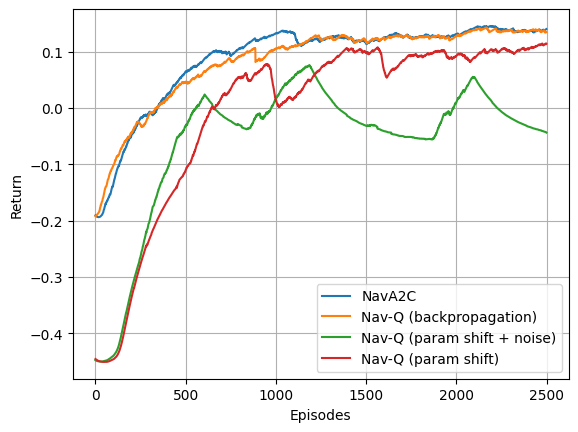

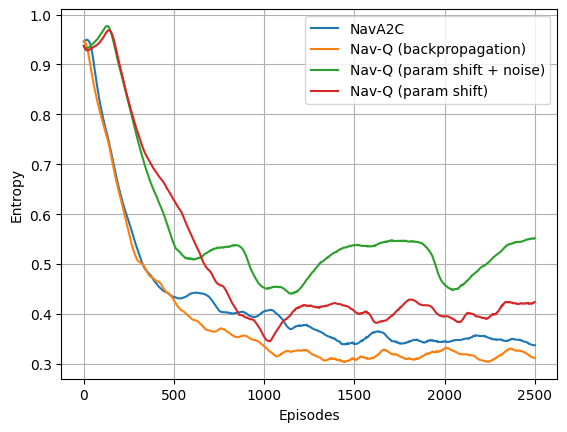

In [26]:
batch_path = r"D:\Cluster_out_Q-NavSACp\Experiments\A2C_Exp\02.06\vel_fix\Deter\LS_6"
out = import_data_from_multiple_runs(batch_path)
sub_dirs = [x for x in os.walk(batch_path)][0][1]
sub_dirs =['_'.join(s.split('_')[2:]) for s in sub_dirs]
# Data Structure creation for plots
data_len=2500
data = {}
data_e ={}
for k,v, e in zip(sub_dirs, out['r'], out['e']):
    # k = format_key_names(k)
    if 'back_prop' in k:
        k = "Nav-Q (backpropagation)"
    elif 'param_shift_wo_noise' in k:
        k = "Nav-Q (param shift)"
    elif 'param_shift' in k:
        k = "Nav-Q (param shift + noise)"
    else:
        k = "NavA2C"
    r, _ = smooth(v[:data_len])
    e, _ = smooth(e[:data_len])
    # r = v[:data_len]
    data[k] = r
    data_e[k] = e
plot_batch_return(data)
plot_batch_return(data_e, ylabel="Entropy", loc="upper right")



In [10]:
for key, value in data.items():
    print (f"key= {key}; AUC = {calc_auc(value)}")
    

key= q=4,l=1; AUC = 1262.7978876591078
key= q=4,l=2; AUC = 1250.923963454552
key= q=4,l=3; AUC = 1189.447678119992


In [30]:
batch_path  = r"D:\Cluster_out_Q-NavSACp\Experiments\A2C_Exp\02.06\vel_fix\Deter\Multi_Runs\C_A2C_ls_32_multi_runs"
c_out = import_data_from_multiple_runs(batch_path)

In [31]:
q_batch_path  = r"D:\Cluster_out_Q-NavSACp\Experiments\A2C_Exp\02.06\vel_fix\Deter\Multi_Runs\Q_A2C_ls_32_q_4_l_1_multi_runs"
q_out = import_data_from_multiple_runs(q_batch_path)

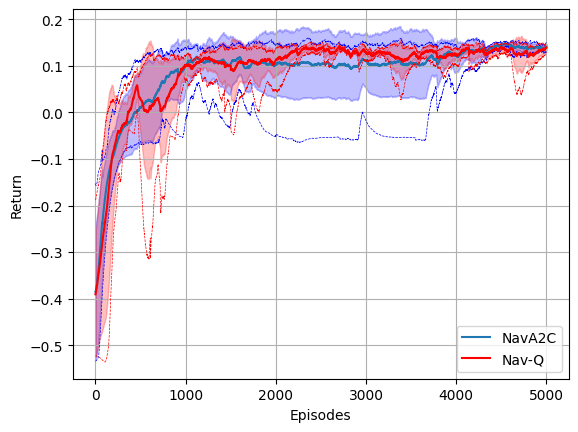

In [32]:
c_r, c_std_r, c_range_r, c_e, c_ci_e, c_range_e = get_inference(c_out)
q_r, q_std_r, q_range_r, q_e, q_ci_e, q_range_e = get_inference(q_out)
plt.plot(c_r, label="NavA2C")
plt.fill_between(range(5000), (c_r-c_std_r), (c_r+c_std_r), color='blue', alpha=0.25)
plt.plot(c_range_r[0], linewidth = 0.5, color ="blue", linestyle='dashed')
plt.plot(c_range_r[1], linewidth = 0.5, color ="blue", linestyle='dashed')

plt.plot(q_r, label="Nav-Q", color="red")
plt.fill_between(range(5000), (q_r-q_std_r), (q_r+q_std_r), color='red', alpha=0.25)
plt.plot(q_range_r[0], linewidth = 0.5, color ="red", linestyle='dashed')
plt.plot(q_range_r[1], linewidth = 0.5, color ="red", linestyle='dashed')

plt.grid()
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.legend(loc="lower right")

In [41]:
# Calculate the mean and std of AUC
q_auc = np.array([calc_auc(q_out['r'][i]) for i in range(len(q_out['r']))])
c_auc = np.array([calc_auc(c_out['r'][i]) for i in range(len(q_out['r']))])


In [48]:
print(f"NavA2C AUC Mean = {c_auc.mean()} ; AUC variance = {c_auc.var()}")
print(f"NavQ (q=4, l=1) AUC Mean = {q_auc.mean()} ; AUC variance = {q_auc.var()}")


NavA2C AUC Mean = 617.9403391580272 ; AUC variance = 9088.913523267956
NavQ (q=4, l=1) AUC Mean = 613.7249732957911 ; AUC variance = 86323.56531021777


In [40]:
q_auc

[1262.7978876591078,
 392.23146839044057,
 533.3742077741772,
 488.2529517582152,
 522.8328759508149,
 482.8604482419905]

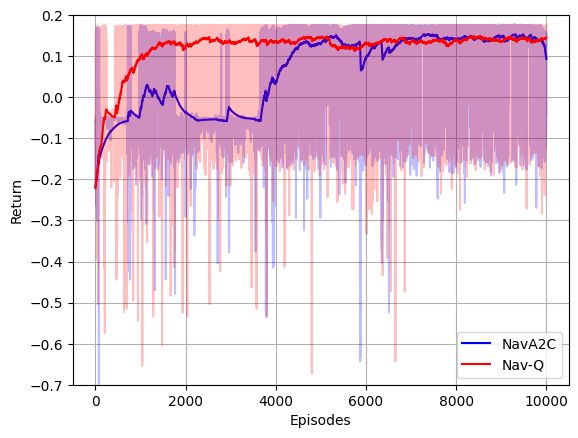

In [33]:
returns_list, _, _ = get_data_from_single_run(path=r"D:\Cluster_out_Q-NavSACp\Experiments\A2C_Exp\02.06\vel_fix\Deter\Multi_Runs\C_A2C_ls_32_multi_runs\A2C_ls_32_fix_ec_0_lr_0.0005_06022023_131640\summary")
q_returns_list, _, _ = get_data_from_single_run(path=r"D:\Cluster_out_Q-NavSACp\Experiments\A2C_Exp\02.06\vel_fix\Deter\Multi_Runs\Q_A2C_ls_32_q_4_l_1_multi_runs\06072023_140745_q_4_l_1_ls_32\summary")
c_color = "blue"
q_color = "red"
l = 10000
smoothed_return, var = smooth(returns_list[:l], weight)
q_smoothed_return, q_var = smooth(q_returns_list, weight)
plt.plot(smoothed_return, color= c_color, label="NavA2C")
plt.plot(returns_list[:l], color =c_color, alpha=0.25)

q_smoothed_return, var = smooth(q_returns_list[:l], weight)
plt.plot(q_smoothed_return, label="Nav-Q", color=q_color)
plt.plot(q_returns_list[:l], color =q_color, alpha=0.25)



plt.grid()
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.legend(loc="lower right")
plt.ylim(-0.7, 0.2)

plt.show()



# Part 2: Code to process pickel file: Driving Policy Analysis

In [13]:
# Processing the pickle files | Evaluation results
path = r"D:\Cluster_out_Q-NavSACp\Experiments\A2C_Exp\02.06\vel_fix\Deter\Q_A2C_ls_32_fix_ec_0_lr_0.0005\q-4\06072023_140745_q_4_l_1_ls_32\11092023_215546.pkl"
data = pickle.load(open(path, "rb" ))
total_data = len(data.keys())
num_crashes = 0
num_goals = 0
num_nm=0
ttg = 0
reward = 0
check =[]
for i in range(1, total_data):
    if data[i]["goal"]:
        ttg += data[i]["ttg"]
    reward += data[i]["total_episode_reward"]
    num_crashes += data[i]["crash"]
    num_nm += data[i]["nearmiss"] 
    num_goals += data[i]["goal"]
    if not data[i]["goal"] and not data[i]["crash"]:
        check.append(data[i])

print("mean ttg: {}, percentage_crashes: {}, percentage_near_misses: {}, percentage_goals: {}, mean return: {}".format \
      (ttg/total_data, num_crashes/total_data*100, num_nm/total_data*100, num_goals/total_data*100, reward/total_data))
    

mean ttg: 12.657919895340626, percentage_crashes: 13.907617993358157, percentage_near_misses: 25.03773774781121, percentage_goals: 86.08231860722552, mean return: 0.12018487916283097


IndexError: single positional indexer is out-of-bounds

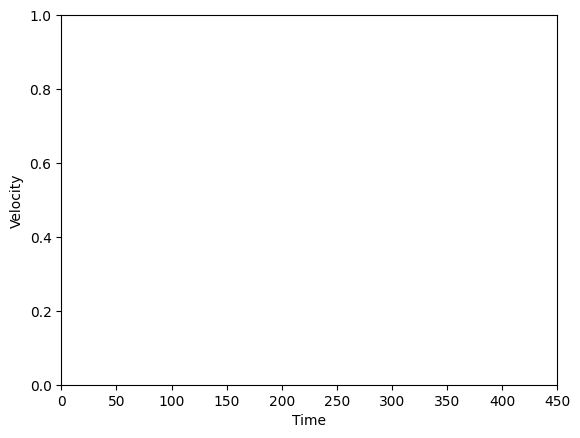

In [14]:
# plot_index = 1
data_pd= pd.DataFrame(data).T
refined_data = data_pd[["scenario", "impact_speed"]]

for sc in set(refined_data["scenario"]):
    plt.xlabel("Time")
    plt.ylabel("Velocity")
    for i in range(50):
        r = random.randint(0, 1241)
        plt.xlim((0,450))
        plt.plot(np.array(refined_data[refined_data["scenario"]==sc]["impact_speed"].iloc[r])*3.6, )
        

    plt.grid()
    plt.savefig(sc+'_q_plot.png')
    time.sleep(2)
    plt.show()


###### Code to calculate safety index

In [16]:
crash_th = 20
nearmiss_th = 20
data_pd= pd.DataFrame(data).T
refined_data = data_pd[["total_episode_reward", "scenario", "crash", "nearmiss", "goal"]]
refined_data["crash"] = refined_data["crash"].astype(dtype=bool)
rd_summary = refined_data.groupby(['scenario']).sum()
counts = refined_data["scenario"].value_counts()
rd_summary["count"] = counts
rd_summary["crash_rate"]=rd_summary["crash"]/rd_summary["count"]* 100
rd_summary["nearmiss_rate"]=rd_summary["nearmiss"]/rd_summary["count"]* 100
# rd_summary["safety"] = (rd_summary["crash_rate"] < crash_th).bool() & (rd_summary["nearmiss_rate"] < nearmiss_th).bool()
x = rd_summary["nearmiss_rate"]<nearmiss_th 
y = rd_summary["crash_rate"]<crash_th
rd_summary["safety"] = x & y
print(rd_summary)
SI = rd_summary["safety"].sum()
print("Safety Index: ", SI)

C:\Users\aksi01\AppData\Local\Temp\ipykernel_520\3644684119.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  refined_data["crash"] = refined_data["crash"].astype(dtype=bool)


TypeError: unsupported operand type(s) for /: 'str' and 'int'

# Part 3: Code to print number of paramters

In [20]:
# n_params 
import torch
model_path = r"D:\Cluster_out_Q-NavSACp\Experiments\A2C_Exp\A2C_sc_01_02_03\03172023_170422\model\a2c_entropy_3000.pth"
model_dict = torch.load(model_path, map_location=torch.device("cpu"))
n_params = {}
n_params["shared"] = 0
n_params["actor"] = 0
n_params["critic"] = 0
for key, value in model_dict.items():
    if "shared_network" in key:
        n_params["shared"] += torch.numel(model_dict[key])
    if "value_network" in key:
        n_params["critic"] += torch.numel(model_dict[key])
    if "action_policy" in key:
        n_params["actor"] += torch.numel(model_dict[key])

print (n_params)

{'shared': 3482528, 'actor': 16643, 'critic': 16513}


# Part 4: Code to plot eigen values

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate


In [79]:
f = np.load(r"D:\Q-DRL-for-CFN\Carla-CTS02\_fishers\trained_param_09012023_160219_f_hat_num_traj_50_traj_len_50_q_4_l_2.npy")

In [80]:
f.shape

(50, 53, 53)

In [81]:
e1=[]
for i in range(len(f)):
    e1.append(np.linalg.eigh(f[i])[0])

len(e1[0])

53

In [82]:
e1 = np.average(e1, axis=0)
e1.sort()
e1 = e1[::-1]

In [83]:
e1

array([ 5.16397171e+01,  1.10310864e+00,  1.77355111e-01,  5.77242561e-02,
        1.41917709e-02,  4.30975482e-03,  1.76693662e-03,  8.31678684e-04,
        4.38558374e-04,  2.32133621e-04,  1.29761553e-04,  7.20084427e-05,
        4.59203511e-05,  3.32118652e-05,  2.12519753e-05,  1.62197521e-05,
        1.08675049e-05,  5.86276292e-06,  4.33957484e-06,  2.71732551e-06,
        1.64012772e-06,  1.18569460e-06,  8.50926824e-07,  5.81697691e-07,
        3.53059392e-07,  2.59591189e-07,  1.77355489e-07,  1.47418746e-07,
        9.69236709e-08,  8.16168253e-08,  6.67003661e-08,  4.60674485e-08,
        3.27094725e-08,  2.51854537e-08,  1.93270466e-08,  1.20198376e-08,
        9.45803347e-09,  6.03812067e-09,  3.52135365e-09,  1.12884413e-09,
       -7.71222308e-10, -2.79991497e-09, -4.36995684e-09, -7.19633597e-09,
       -1.10468275e-08, -1.60738267e-08, -2.76435639e-08, -4.33035332e-08,
       -5.86070925e-08, -9.16079088e-08, -1.41782934e-07, -2.42521764e-07,
       -5.89943568e-07], 

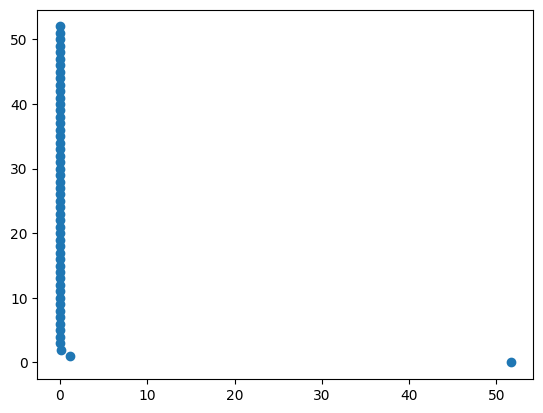

In [84]:
plt.scatter(e1[0:53], range(0,53),)

list